In [1]:
%load_ext autoreload
%autoreload 2

from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import scipy as sp
from sklearn import linear_model

from fama_french import load_monthly_factors, ff_display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = 12, 6

# Betterment Performance Data

Betterment's performance data is located on [their performance page](https://www.betterment.com/resources/betterment-historical-performance/) in an IFrame [that points to CloudFront](https://d1svladlv4b69d.cloudfront.net/src/d3/bmt-hist-perf-line-graph/bmt-hist-perf.html).  We downloaded the HTML of the latter on June 21st.

In [3]:
with open("data/Betterment_Performance.html") as fh:
    soup = BeautifulSoup(fh)
    paths = soup.select("g.g-linecontainer path.g-port-line")


## SVG Graphics

SVG graphics language is an `M[x],[y]` followed by a series of `L[x],[y]` commands ([source](https://developer.mozilla.org/en-US/docs/Web/SVG/Tutorial/Paths)).  They can be parsed from "path" objects.  Remember that the x coordinates increase left to right but the y coordinates increase *up to down* ([source](https://www.w3.org/TR/SVG/coords.html)), as with most coodinate systems for monitor displays.

In an email, Betterment staff explained that the returns dated from the end of the month.

In [4]:
# extract Jan 2004 to Feb 2019 (inclusive) values
dates = pd.date_range(start='2004/1/31', end='2019/2/28', freq='M')

def extract_y_coors(data):
    assert(data.startswith('M'))
    pairs = [[float(x) for x in pair.split(',')] for pair in data[1:].split('L')]
    assert(len(pairs) == len(dates))
    return [y for _, y in pairs]

df_y = pd.DataFrame({
    path.get('class')[1]: extract_y_coors(path.get('d'))
    for path in paths
}, index=dates).sort_index()

df_y.tail()


,sp500,bmt100,bmt90,bmt80,bmt70,bmt60,bmt50,arc90,bmt40,arc70,bmt30,arc50,bmt20,arc30,tBillFiveYear,bmt10,bmt0
2018-10-31,170.775383,202.890228,215.271566,229.386392,243.772043,259.512120,275.115015,292.934511,294.273350,308.020408,318.620544,329.148161,341.131677,348.365767,353.509172,361.758855,380.478592
2018-11-30,164.693801,196.469022,209.569670,224.435519,239.514242,255.956349,272.190415,289.434571,292.018606,306.211663,317.050883,328.267733,340.125891,348.112342,353.157105,361.207331,380.283313
2018-12-31,194.095807,219.506013,228.983556,240.348290,252.222506,265.667843,279.242003,302.496131,296.760893,314.648834,320.095164,333.580762,341.802337,349.926239,352.836172,361.809996,380.069927
2019-01-31,169.713198,195.745954,207.951434,222.042486,236.497121,252.414333,268.255538,289.353984,288.231552,305.453852,314.357799,327.478384,338.338211,346.653300,352.531162,360.151851,379.806212
2019-02-28,159.051086,187.940678,201.232324,216.368741,231.791120,248.606233,265.251440,284.542966,285.988979,301.977820,312.819141,325.424053,337.370215,345.589342,352.231359,359.635952,379.638450


## Parse Returns Table

In [5]:
def parse_percent(x):
    if isinstance(x, str) and x.endswith('%'):
        return float(x[:-1]) / 100
    return x

with open("data/Betterment_Performance.html") as fh:
    df_raw = pd.read_html(fh)[0]
    df_r = pd.DataFrame(
        df_raw.iloc[2:,:].values,
        columns=df_raw.iloc[1,:].values
    ).set_index('Portfolio').applymap(parse_percent)
    
df_r

,Avg. Annual Return,Cumulative Return,Sharpe Ratio,Best month,Worst month,Last 12 months
Portfolio,,,,,,
S&P 500 Index,0.083,2.318,0.55,0.109,-0.165,0.045
Betterment 100% stock,0.076,2.036,0.47,0.131,-0.202,-0.007
Betterment 90% stock,0.073,1.906,0.48,0.120,-0.187,-0.003
Betterment 80% stock,0.070,1.758,0.48,0.109,-0.173,0.001
Betterment 70% stock,0.066,1.607,0.49,0.098,-0.159,0.005
Betterment 60% stock,0.061,1.443,0.50,0.087,-0.146,0.009
Betterment 50% stock,0.056,1.280,0.50,0.077,-0.134,0.013
Avg. private client investor 80-100% equity risk,0.050,1.092,0.36,0.085,-0.160,0.003
Betterment 40% stock,0.050,1.078,0.50,0.064,-0.117,0.016


# Join path data and Return Table

We're in luck -- the data aligns so it's easy to join them

In [6]:
label_dict = dict(zip(df_y.columns, df_r.index))
label_dict

{'sp500': 'S&P 500 Index',
 'bmt100': 'Betterment 100% stock',
 'bmt90': 'Betterment 90% stock',
 'bmt80': 'Betterment 80% stock',
 'bmt70': 'Betterment 70% stock',
 'bmt60': 'Betterment 60% stock',
 'bmt50': 'Betterment 50% stock',
 'arc90': 'Avg. private client investor 80-100% equity risk',
 'bmt40': 'Betterment 40% stock',
 'arc70': 'Avg. private client investor 60-80% equity risk',
 'bmt30': 'Betterment 30% stock',
 'arc50': 'Avg. private client investor 40-60% equity risk',
 'bmt20': 'Betterment 20% stock',
 'arc30': 'Avg. private client investor 0-40% equity risk',
 'tBillFiveYear': 'Five year U.S. Treasury Bills',
 'bmt10': 'Betterment 10% stock',
 'bmt0': 'Betterment 0% stock'}

In [7]:
if set(df_y.columns) != set(label_dict.values()):
    df_y.columns = [label_dict[x] for x in df_y.columns]
df_y.tail()

,S&P 500 Index,Betterment 100% stock,Betterment 90% stock,Betterment 80% stock,Betterment 70% stock,Betterment 60% stock,Betterment 50% stock,Avg. private client investor 80-100% equity risk,Betterment 40% stock,Avg. private client investor 60-80% equity risk,Betterment 30% stock,Avg. private client investor 40-60% equity risk,Betterment 20% stock,Avg. private client investor 0-40% equity risk,Five year U.S. Treasury Bills,Betterment 10% stock,Betterment 0% stock
2018-10-31,170.775383,202.890228,215.271566,229.386392,243.772043,259.512120,275.115015,292.934511,294.273350,308.020408,318.620544,329.148161,341.131677,348.365767,353.509172,361.758855,380.478592
2018-11-30,164.693801,196.469022,209.569670,224.435519,239.514242,255.956349,272.190415,289.434571,292.018606,306.211663,317.050883,328.267733,340.125891,348.112342,353.157105,361.207331,380.283313
2018-12-31,194.095807,219.506013,228.983556,240.348290,252.222506,265.667843,279.242003,302.496131,296.760893,314.648834,320.095164,333.580762,341.802337,349.926239,352.836172,361.809996,380.069927
2019-01-31,169.713198,195.745954,207.951434,222.042486,236.497121,252.414333,268.255538,289.353984,288.231552,305.453852,314.357799,327.478384,338.338211,346.653300,352.531162,360.151851,379.806212
2019-02-28,159.051086,187.940678,201.232324,216.368741,231.791120,248.606233,265.251440,284.542966,285.988979,301.977820,312.819141,325.424053,337.370215,345.589342,352.231359,359.635952,379.638450


In [8]:
df_ry = pd.merge(
    df_r, df_y.iloc[-1:, :].T,
    right_index=True,
    left_index=True
)
df_ry

,Avg. Annual Return,Cumulative Return,Sharpe Ratio,Best month,Worst month,Last 12 months,2019-02-28 00:00:00
S&P 500 Index,0.083,2.318,0.55,0.109,-0.165,0.045,159.051086
Betterment 100% stock,0.076,2.036,0.47,0.131,-0.202,-0.007,187.940678
Betterment 90% stock,0.073,1.906,0.48,0.120,-0.187,-0.003,201.232324
Betterment 80% stock,0.070,1.758,0.48,0.109,-0.173,0.001,216.368741
Betterment 70% stock,0.066,1.607,0.49,0.098,-0.159,0.005,231.791120
Betterment 60% stock,0.061,1.443,0.50,0.087,-0.146,0.009,248.606233
Betterment 50% stock,0.056,1.280,0.50,0.077,-0.134,0.013,265.251440
Avg. private client investor 80-100% equity risk,0.050,1.092,0.36,0.085,-0.160,0.003,284.542966
Betterment 40% stock,0.050,1.078,0.50,0.064,-0.117,0.016,285.988979
Avg. private client investor 60-80% equity risk,0.044,0.922,0.38,0.067,-0.119,-0.006,301.977820


## Connect path coodinates with returns

We use the terminal coordinates for each index and match them (via linear regression) against the cumulative returns to infer the monthly returns.

In [9]:
# Slightly overdone use of linear regression
lm = linear_model.LinearRegression()
X = df_ry[[pd.Timestamp('2019-02-28 00:00:00', freq='M')]]
y = df_ry['Cumulative Return'] + 1.  # index values

lm.fit(X, y)
print("R^2: {}".format(lm.score(X, y)))

R^2: 0.999999777266464


In [10]:
df_index = df_y.apply(lambda col: lm.predict(col[:, np.newaxis]))
df_index.head()

,S&P 500 Index,Betterment 100% stock,Betterment 90% stock,Betterment 80% stock,Betterment 70% stock,Betterment 60% stock,Betterment 50% stock,Avg. private client investor 80-100% equity risk,Betterment 40% stock,Avg. private client investor 60-80% equity risk,Betterment 30% stock,Avg. private client investor 40-60% equity risk,Betterment 20% stock,Avg. private client investor 0-40% equity risk,Five year U.S. Treasury Bills,Betterment 10% stock,Betterment 0% stock
2004-01-31,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141,1.000141
2004-02-29,1.013710,1.023066,1.021723,1.020303,1.018885,1.017295,1.015653,1.017914,1.013466,1.013497,1.010195,1.012086,1.006924,1.004918,1.002663,1.003652,1.000376
2004-03-31,1.000284,1.019918,1.019862,1.019715,1.019531,1.019209,1.018802,1.020915,1.017251,1.014244,1.013197,1.016407,1.009117,1.008565,1.004965,1.005016,1.000887
2004-04-30,0.981362,0.978533,0.979485,0.980450,0.981341,0.982058,0.982626,0.997677,0.984319,0.993892,0.988633,0.999900,0.992907,0.996934,1.007759,0.997133,1.001312
2004-05-31,0.998161,0.992444,0.991605,0.990707,0.989781,0.988496,0.987040,0.995963,0.987093,0.990842,0.990916,0.997153,0.994655,0.993866,1.010936,0.998301,1.001854


In [11]:
df_index.to_csv("data/betterment_values.csv")

## Returns

In [12]:
df_returns = pd.DataFrame(
    df_index.iloc[1:,:].values / df_index.iloc[:-1,:].values,
    columns = df_index.columns,
    index = df_index.index[1:]
) - 1.
df_returns['Year'] = df_returns.index.year
df_returns['Month'] = df_returns.index.month
df_returns.head()

,S&P 500 Index,Betterment 100% stock,Betterment 90% stock,Betterment 80% stock,Betterment 70% stock,Betterment 60% stock,Betterment 50% stock,Avg. private client investor 80-100% equity risk,Betterment 40% stock,Avg. private client investor 60-80% equity risk,Betterment 30% stock,Avg. private client investor 40-60% equity risk,Betterment 20% stock,Avg. private client investor 0-40% equity risk,Five year U.S. Treasury Bills,Betterment 10% stock,Betterment 0% stock,Year,Month
2004-02-29,0.013567,0.022922,0.021579,0.020159,0.018742,0.017152,0.015510,0.017771,0.013323,0.013354,0.010053,0.011943,0.006782,0.004776,0.002522,0.003511,0.000235,2004,2
2004-03-31,-0.013244,-0.003077,-0.001821,-0.000577,0.000633,0.001881,0.003100,0.002948,0.003735,0.000737,0.002971,0.004270,0.002177,0.003629,0.002296,0.001358,0.000512,2004,3
2004-04-30,-0.018917,-0.040577,-0.039591,-0.038506,-0.037458,-0.036451,-0.035508,-0.022761,-0.032373,-0.020066,-0.024243,-0.016241,-0.016064,-0.011532,0.002781,-0.007843,0.000424,2004,4
2004-05-31,0.017119,0.014216,0.012374,0.010462,0.008601,0.006555,0.004492,-0.001719,0.002818,-0.003068,0.002308,-0.002747,0.001761,-0.003077,0.003152,0.001171,0.000541,2004,5
2004-06-30,0.018495,0.025600,0.023306,0.021049,0.018742,0.016490,0.014208,0.010237,0.011842,0.005734,0.009093,0.001768,0.006324,0.000782,0.003217,0.003537,0.000730,2004,6


## Betterment performs 0.02% worse than S&P 500

In [13]:
(df_returns['Betterment 100% stock'] - df_returns['S&P 500 Index']).mean() * 12

-0.003182740862128362

In [14]:
df_annual_returns = ((df_returns + 1.)
    .drop(['Year', 'Month'], axis=1)
    .groupby(lambda x: x.year)
    .prod() - 1.)
df_annual_returns.to_csv('data/betterment_annual_returns.csv')
df_annual_returns.loc[[2012, 2013, 2014, 2015, 2016, 2017, 2018]]

,S&P 500 Index,Betterment 100% stock,Betterment 90% stock,Betterment 80% stock,Betterment 70% stock,Betterment 60% stock,Betterment 50% stock,Avg. private client investor 80-100% equity risk,Betterment 40% stock,Avg. private client investor 60-80% equity risk,Betterment 30% stock,Avg. private client investor 40-60% equity risk,Betterment 20% stock,Avg. private client investor 0-40% equity risk,Five year U.S. Treasury Bills,Betterment 10% stock,Betterment 0% stock
2012,0.159876,0.173015,0.161233,0.149446,0.137486,0.125878,0.114208,0.134201,0.098327,0.106736,0.072671,0.087795,0.047367,0.063119,0.007606,0.022442,-0.002125
2013,0.323022,0.240260,0.209735,0.180112,0.151460,0.123392,0.096246,0.168849,0.071840,0.131377,0.053068,0.095143,0.034420,0.041694,0.011717,0.015886,-0.002504
2014,0.134618,0.051864,0.052185,0.051981,0.052263,0.052089,0.052548,0.029583,0.048463,0.025912,0.035723,0.025001,0.022985,0.018930,0.016405,0.010253,-0.002445
2015,0.012343,-0.031294,-0.027207,-0.023008,-0.019097,-0.015097,-0.011339,-0.018069,-0.008041,-0.014102,-0.006254,-0.013808,-0.004727,-0.008337,0.015288,-0.003460,-0.002455
2016,0.119965,0.110467,0.104583,0.098256,0.092211,0.086119,0.080457,0.029299,0.070857,0.026800,0.053559,0.025011,0.036235,0.024993,0.013378,0.018913,0.001605
2017,0.217033,0.225760,0.205982,0.186561,0.167043,0.148114,0.129191,0.194232,0.108162,0.149570,0.081308,0.106880,0.055037,0.062257,0.019095,0.029352,0.004229
2018,-0.045688,-0.104475,-0.093707,-0.083151,-0.072359,-0.061912,-0.051245,-0.076584,-0.039968,-0.067825,-0.026241,-0.057057,-0.012552,-0.032752,0.027477,0.001068,0.014633


## Load Monthly Fama French Factors

In [15]:
df_factors = load_monthly_factors()
df_factors.head()


,YearMonth,Mkt-RF,SMB,HML,RF,Alpha,Year,Month
0,192607,0.0296,-0.0230,-0.0287,0.0022,1.0,1926,7
1,192608,0.0264,-0.0140,0.0419,0.0025,1.0,1926,8
2,192609,0.0036,-0.0132,0.0001,0.0023,1.0,1926,9
3,192610,-0.0324,0.0004,0.0051,0.0032,1.0,1926,10
4,192611,0.0253,-0.0020,-0.0035,0.0031,1.0,1926,11


In [16]:
df = df_returns.merge(
    df_factors,
    on=('Year', 'Month'),
    how='inner'
)

df.head()

,S&P 500 Index,Betterment 100% stock,Betterment 90% stock,Betterment 80% stock,Betterment 70% stock,Betterment 60% stock,Betterment 50% stock,Avg. private client investor 80-100% equity risk,Betterment 40% stock,Avg. private client investor 60-80% equity risk,...,Betterment 10% stock,Betterment 0% stock,Year,Month,YearMonth,Mkt-RF,SMB,HML,RF,Alpha
0,0.013567,0.022922,0.021579,0.020159,0.018742,0.017152,0.015510,0.017771,0.013323,0.013354,...,0.003511,0.000235,2004,2,200402,0.0140,-0.0143,0.0049,0.0006,1.0
1,-0.013244,-0.003077,-0.001821,-0.000577,0.000633,0.001881,0.003100,0.002948,0.003735,0.000737,...,0.001358,0.000512,2004,3,200403,-0.0132,0.0175,0.0021,0.0009,1.0
2,-0.018917,-0.040577,-0.039591,-0.038506,-0.037458,-0.036451,-0.035508,-0.022761,-0.032373,-0.020066,...,-0.007843,0.000424,2004,4,200404,-0.0183,-0.0206,-0.0262,0.0008,1.0
3,0.017119,0.014216,0.012374,0.010462,0.008601,0.006555,0.004492,-0.001719,0.002818,-0.003068,...,0.001171,0.000541,2004,5,200405,0.0117,-0.0021,-0.0039,0.0006,1.0
4,0.018495,0.025600,0.023306,0.021049,0.018742,0.016490,0.014208,0.010237,0.011842,0.005734,...,0.003537,0.000730,2004,6,200406,0.0186,0.0226,0.0138,0.0008,1.0


# Perhaps slighty worse with Fama French

,S&P 500 Index,Betterment 100% stock,Betterment 80% stock,Betterment 70% stock,Betterment 60% stock,Betterment 50% stock,Avg. private client investor 80-100% equity risk,Betterment 40% stock,Avg. private client investor 60-80% equity risk,Betterment 30% stock,Avg. private client investor 40-60% equity risk,Betterment 20% stock,Avg. private client investor 0-40% equity risk,Five year U.S. Treasury Bills,Betterment 10% stock,Betterment 0% stock
Mkt-RF,0.994447,1.062591,0.870832,0.775443,0.682594,0.590293,0.815887,0.489286,0.607235,0.365327,0.426790,0.241644,0.231667,-0.000399,0.118395,-0.004448
SMB,-0.138055,-0.054567,-0.062134,-0.065228,-0.069250,-0.072072,-0.124277,-0.069849,-0.083832,-0.052273,-0.071167,-0.034652,-0.059421,0.001966,-0.017031,0.000645
HML,0.000861,0.061445,0.034833,0.021923,0.009152,-0.003214,-0.103090,-0.011146,-0.098248,-0.008408,-0.083631,-0.005383,-0.063876,0.000338,-0.002066,0.001567
Alpha,-0.000246,-0.001014,-0.000580,-0.000385,-0.000234,-0.000091,-0.001865,-0.000020,-0.001199,-0.000038,-0.000832,-0.000065,-0.000299,0.000965,-0.000102,-0.000151
R^2,0.996207,0.931281,0.915787,0.902848,0.882113,0.850579,0.883195,0.815695,0.864249,0.812702,0.811911,0.806992,0.701890,0.004727,0.786302,0.056200


,S&P 500 Index,Betterment 100% stock,Betterment 80% stock,Betterment 70% stock,Betterment 60% stock,Betterment 50% stock,Avg. private client investor 80-100% equity risk,Betterment 40% stock,Avg. private client investor 60-80% equity risk,Betterment 30% stock,Avg. private client investor 40-60% equity risk,Betterment 20% stock,Avg. private client investor 0-40% equity risk,Five year U.S. Treasury Bills,Betterment 10% stock,Betterment 0% stock
Mkt-RF,0.081292,0.086862,0.071187,0.063389,0.055799,0.048254,0.066695,0.039997,0.049639,0.029864,0.034888,0.019753,0.018938,-0.000033,0.009678,-0.000364
SMB,-0.001451,-0.000573,-0.000653,-0.000685,-0.000728,-0.000757,-0.001306,-0.000734,-0.000881,-0.000549,-0.000748,-0.000364,-0.000624,0.000021,-0.000179,0.000007
HML,-0.000006,-0.000422,-0.000239,-0.000150,-0.000063,0.000022,0.000707,0.000076,0.000674,0.000058,0.000574,0.000037,0.000438,-0.000002,0.000014,-0.000011
Alpha,-0.002955,-0.012170,-0.006960,-0.004614,-0.002804,-0.001093,-0.022382,-0.000243,-0.014388,-0.000452,-0.009985,-0.000775,-0.003589,0.011583,-0.001230,-0.001816


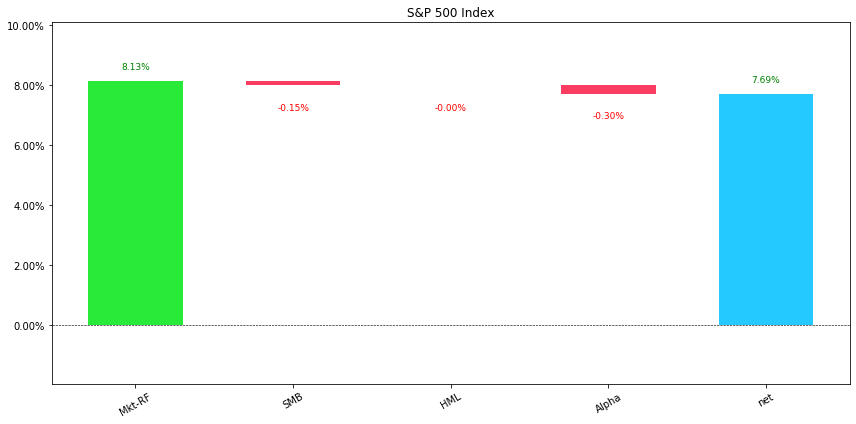

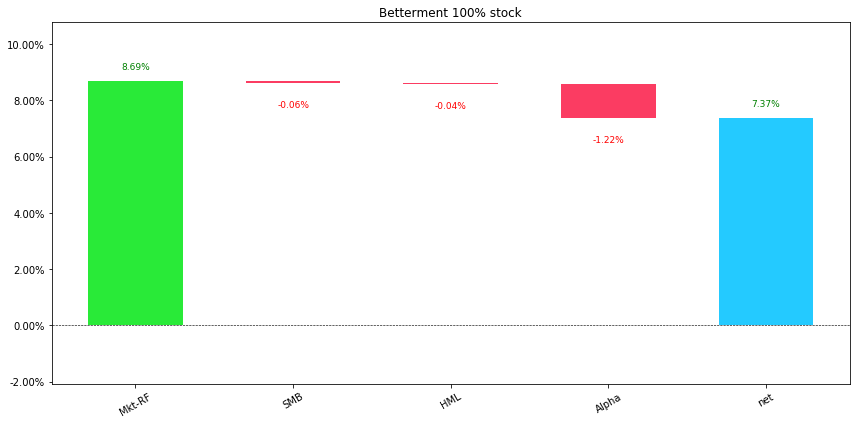

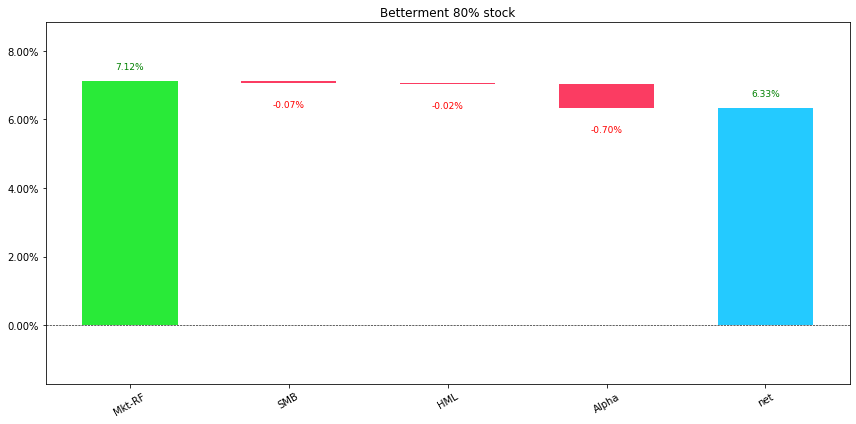

In [17]:
index_cols = [
   'S&P 500 Index', 'Betterment 100% stock',
   'Betterment 80% stock', 'Betterment 70% stock', 'Betterment 60% stock',
   'Betterment 50% stock',
   'Avg. private client investor 80-100% equity risk',
   'Betterment 40% stock',
   'Avg. private client investor 60-80% equity risk',
   'Betterment 30% stock',
   'Avg. private client investor 40-60% equity risk',
   'Betterment 20% stock',
   'Avg. private client investor 0-40% equity risk',
   'Five year U.S. Treasury Bills', 'Betterment 10% stock',
   'Betterment 0% stock'
]

waterfall_cols = [
    'S&P 500 Index', 'Betterment 100% stock',
    'Betterment 80% stock'
]

ff_display(df, index_cols, waterfall_cols, monthly=True)